# FQI on Car On Hill

## Define parameters

In [11]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import jax
import jax.numpy as jnp


gamma = 0.95
n_actions = 2

# Sample collection
oriented_state = jnp.array([0.5, 0.38])
n_random_samples = 3500
n_oriented_samples = 500
n_samples = n_random_samples + n_oriented_samples

# Trainings
layers_dimension = (7, 7)
max_bellman_iterations = 15
batch_size_samples = n_samples

## FQI
fitting_steps = 400 * 20
batch_size_weights = 1
learning_rate = {"first": 0.001, "last": 0.00005, "duration": fitting_steps * n_samples // batch_size_samples}

# Visualisation of errors and performances
n_states_x = 17
n_states_v = 17
horizon = 100
plot_freq = 10

# Search for an unused seed
max_used_seed = 0
for file in os.listdir("figures/data/FQI/"):
    if int(file.split("_")[0]) == max_bellman_iterations and int(file.split("_")[2][:-4]) > max_used_seed:
        max_used_seed = int(file.split("_")[2][:-4])
max_used_seed

# keys
seed = max_used_seed + 1
seed_sample = 0
sample_key = jax.random.PRNGKey(seed_sample)
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, pbo_network_key = jax.random.split(key, 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define environment

In [12]:
from pbo.environment.car_on_hill import CarOnHillEnv


max_pos = 1.0
max_velocity = 3.0

states_x = jnp.linspace(-max_pos, max_pos, n_states_x)
boxes_x_size = (2 * max_pos) / (n_states_x - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x + 1) - boxes_x_size / 2)
states_v = jnp.linspace(-max_velocity, max_velocity, n_states_v)
boxes_v_size = (2 * max_velocity) / (n_states_v - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh and with a uniform policy

In [13]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

env.reset()
n_episodes = 0
n_steps = 0
for idx_sample in range(n_random_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon:
        env.reset()
        n_episodes += 1
        n_steps = 0


env.reset(oriented_state)
n_episodes += 1
n_steps = 0
for idx_sample in range(n_oriented_samples):
    state = env.state
    
    sample_key, key = jax.random.split(sample_key)
    if jax.random.uniform(key) > 0.5:
        action = jnp.array([0])
    else:
        action = jnp.array([1])
    next_state, reward, absorbing, _ = env.step(action)
    n_steps += 1

    replay_buffer.add(state, action, reward, next_state, absorbing)

    if absorbing or n_steps > horizon:
        sample_key, key = jax.random.split(sample_key)
        env.reset(jax.random.normal(key, (2,)) / 2 + oriented_state)

        n_episodes += 1
        n_steps = 0

replay_buffer.cast_to_jax_array()
assert sum(replay_buffer.rewards == 1) > 0, "No positive reward has been sampled, please do something!"
print(f"Number of episodes: {n_episodes}")

Number of episodes: 96


In [14]:
replay_buffer.actions[(replay_buffer.rewards == 1).flatten()]

DeviceArray([[1],
             [1],
             [0],
             [1],
             [0],
             [1],
             [0],
             [1],
             [0],
             [0],
             [1],
             [1],
             [0]], dtype=int32)

### Visualize samples

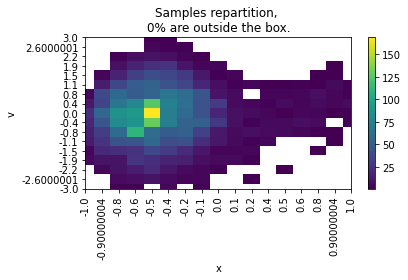

In [15]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes, rewards_count = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes, replay_buffer.rewards)
samples_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

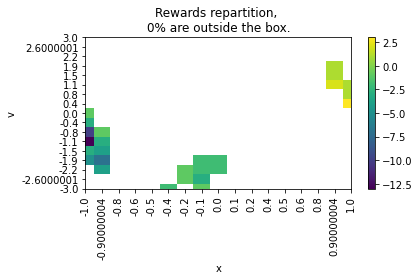

In [16]:
samples_visu_mesh.set_values(rewards_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Rewards repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Train FQI

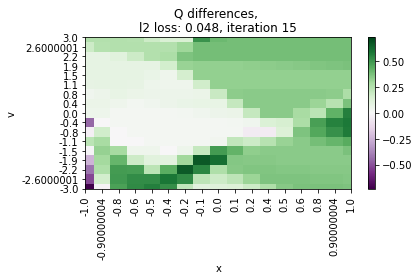

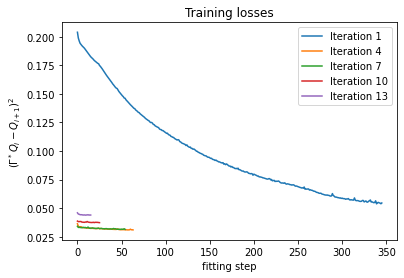

In [17]:
import matplotlib.pyplot as plt

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=None,
    learning_rate=learning_rate,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)
iterated_q = np.zeros((max_bellman_iterations, n_states_x, n_states_v, n_actions))
iterated_v = np.zeros((max_bellman_iterations, n_states_x, n_states_v))

q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0, axis_equal=False, zero_centered=True)
l2_losses = np.ones((max_bellman_iterations, fitting_steps)) * np.nan

for bellman_iteration in range(max_bellman_iterations):
    params_target = q.params
    best_loss = float('inf')
    patience = 0

    for step in range(fitting_steps):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss
        if cumulative_l2_loss < best_loss:
            patience = 0
            best_loss = cumulative_l2_loss
        else:
            patience += 1
        
        if patience > 5:
            break

    diff_q = env.diff_q_mesh(q, states_x, states_v)

    q_visu_mesh.set_values(diff_q)
    q_visu_mesh.show(f"Q differences, \nl2 loss: {str(jnp.round(cumulative_l2_loss, 3))}, iteration {bellman_iteration + 1}", xlabel="x", ylabel="v")

    iterated_q[bellman_iteration] = env.q_mesh(q, states_x, states_v)
    iterated_v[bellman_iteration] = env.v_mesh(q, horizon, states_x, states_x)

for bellman_iteration in range(0, max_bellman_iterations, max(max_bellman_iterations // 5, 1)):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

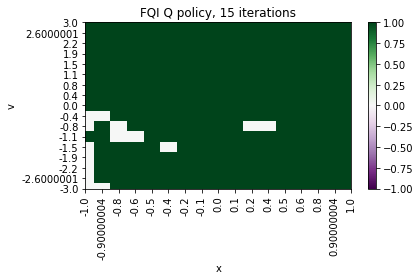

In [18]:
q_visu_mesh.set_values((diff_q > 0).astype(float))
q_visu_mesh.show(f"FQI Q policy, {max_bellman_iterations} iterations", xlabel="x", ylabel="v")

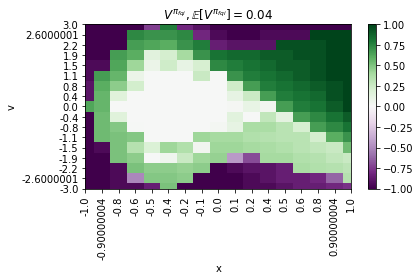

In [19]:
v_mesh = env.v_mesh(q, horizon, states_x, states_v)

q_visu_mesh.set_values(v_mesh)
q_visu_mesh.show(r"$V^{\pi_{fqi}}, \mathbb{E}\left[ V^{\pi_{fqi}} \right] =$" + str(np.round(np.mean(v_mesh), 2)), xlabel="x", ylabel="v")

## Save the data

In [20]:
np.save(f"figures/data/FQI/{max_bellman_iterations}_Q_{seed}.npy", iterated_q)
np.save(f"figures/data/FQI/{max_bellman_iterations}_V_{seed}.npy", iterated_v)